##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c06_forecasting_with_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c06_forecasting_with_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

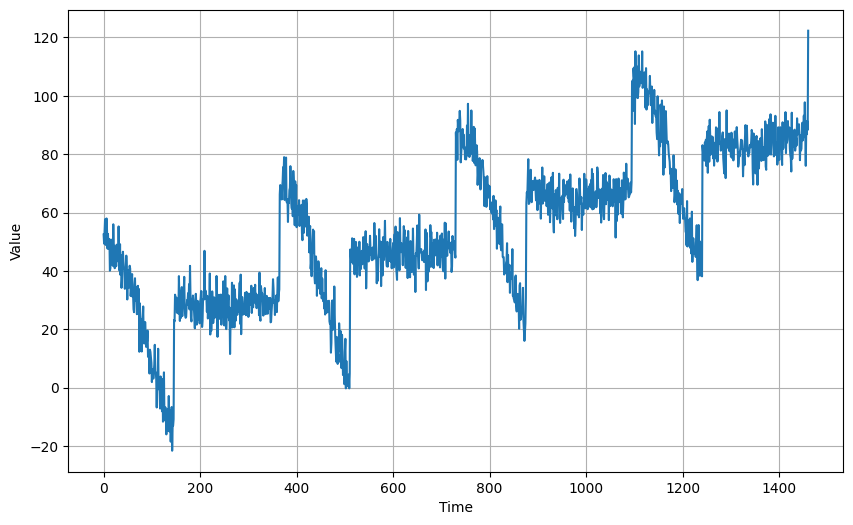

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [23]:
len(x_train), len(x_valid)

(1000, 461)

## Simple RNN Forecasting

In [15]:
for x, y in window_dataset(x_train, window_size, batch_size=128):
  print(x.shape)
  print(y.shape)
  break

(128, 30)
(128,)


In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # Adds a new dimension of size 1
                      input_shape=[None]), # Input shape as None allows to take in any input length
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 40ms/step - loss: 123.7370 - mae: 124.2370 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 37ms/step - loss: 86.7634 - mae: 87.2631 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 0s 36ms/step - loss: 33.1689 - mae: 33.6658 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 0s 35ms/step - loss: 30.1261 - mae: 30.6236 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 0s 34ms/step - loss: 21.6968 - mae: 22.1886 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 0s 34ms/step - loss: 21.6150 - mae: 22.1081 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 0s 35ms/step - loss: 18.6677 - mae: 19.1606 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 0s 44ms/step - loss: 17.0562 - mae: 17.5481 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 1s 58ms/step - loss: 15.6893 - mae: 16.1771 - lr: 2

(1e-07, 0.0001, 0.0, 30.0)

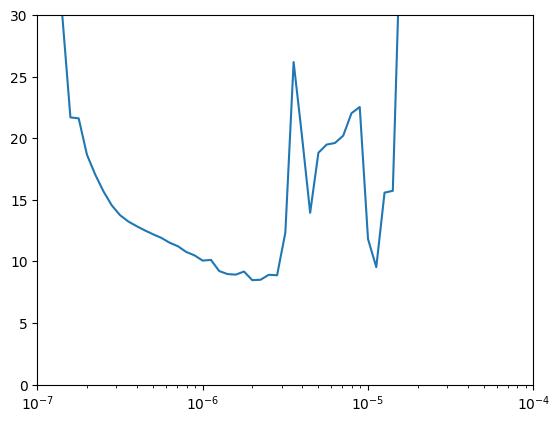

In [16]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

## Training the exact same model, this time using a validation set

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 6s 556ms/step - loss: 19811.2930 - mae: 19811.7910 - val_loss: 1747.1195 - val_mae: 1747.6195
Epoch 2/500
8/8 [==============================] - 1s 60ms/step - loss: 16377.7939 - mae: 16378.2939 - val_loss: 22841.3223 - val_mae: 22841.8223
Epoch 3/500
8/8 [==============================] - 1s 62ms/step - loss: 40240.0586 - mae: 40240.5586 - val_loss: 9834.0391 - val_mae: 9834.5391
Epoch 4/500
8/8 [==============================] - 1s 58ms/step - loss: 76286.9141 - mae: 76287.4141 - val_loss: 156118.6562 - val_mae: 156119.1719
Epoch 5/500
8/8 [==============================] - 1s 60ms/step - loss: 74013.8438 - mae: 74014.3516 - val_loss: 61748.9570 - val_mae: 61749.4531
Epoch 6/500
8/8 [==============================] - 1s 105ms/step - loss: 23125.0723 - mae: 23125.5723 - val_loss: 21197.4336 - val_mae: 21197.9355
Epoch 7/500
8/8 [==============================] - 1s 105ms/step - loss: 16348.0977 - mae: 16348.5977 - val_loss: 10609.8125

In [18]:
model = keras.models.load_model("my_checkpoint")

In [22]:
len(series[split_time - window_size:-1])

490

In [20]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 1s 12ms/step


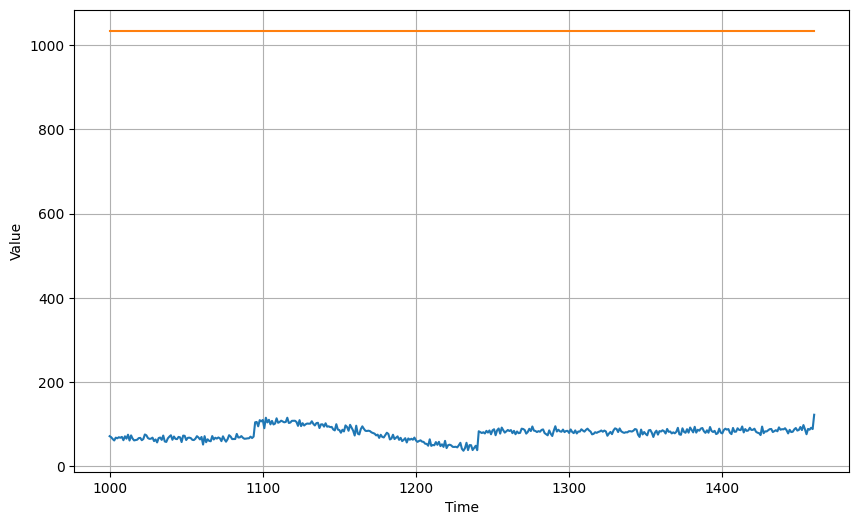

In [24]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [25]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

956.2133

## Sequence-to-Sequence Forecasting

In [35]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:])) # This line is only what makes it different compared to window_dataset
    return ds.batch(batch_size).prefetch(1)

In [36]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]


In [37]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]), # Keras assumes the first dimension can be any batch size. The 'None' means that Keras can handle sequences of any length
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 48ms/step - loss: 350.2284 - mae: 350.7283 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 41ms/step - loss: 307.2961 - mae: 307.7960 - lr: 1.0798e-07
Epoch 3/100
8/8 [==============================] - 0s 41ms/step - loss: 240.8570 - mae: 241.3569 - lr: 1.1659e-07
Epoch 4/100
8/8 [==============================] - 0s 40ms/step - loss: 164.7056 - mae: 165.2055 - lr: 1.2589e-07
Epoch 5/100
8/8 [==============================] - 0s 39ms/step - loss: 84.2238 - mae: 84.7235 - lr: 1.3594e-07
Epoch 6/100
8/8 [==============================] - 0s 39ms/step - loss: 29.8448 - mae: 30.3409 - lr: 1.4678e-07
Epoch 7/100
8/8 [==============================] - 0s 42ms/step - loss: 35.3586 - mae: 35.8567 - lr: 1.5849e-07
Epoch 8/100
8/8 [==============================] - 0s 38ms/step - loss: 23.5215 - mae: 24.0150 - lr: 1.7113e-07
Epoch 9/100
8/8 [==============================] - 0s 40ms/step - loss: 21.3805 - mae: 21.8730 -

(1e-07, 0.0001, 0.0, 30.0)

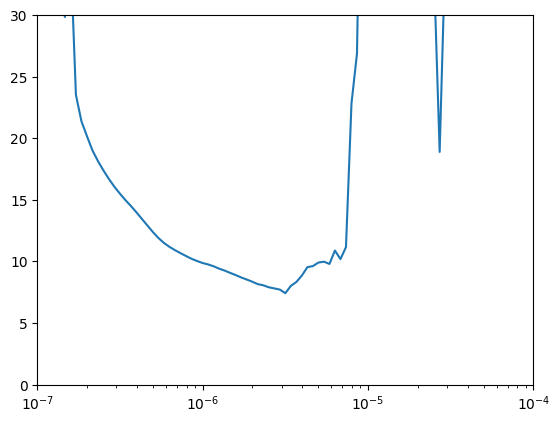

In [38]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [39]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 3s 123ms/step - loss: 11840.0596 - mae: 11840.5615 - val_loss: 2093.4951 - val_mae: 2093.9951
Epoch 2/500
8/8 [==============================] - 1s 60ms/step - loss: 32030.6523 - mae: 32031.1523 - val_loss: 33530.4961 - val_mae: 33531.0000
Epoch 3/500
8/8 [==============================] - 1s 62ms/step - loss: 38007.0781 - mae: 38007.5781 - val_loss: 31878.8262 - val_mae: 31879.3262
Epoch 4/500
8/8 [==============================] - 1s 61ms/step - loss: 36681.2539 - mae: 36681.7539 - val_loss: 47967.4102 - val_mae: 47967.9102
Epoch 5/500
8/8 [==============================] - 1s 70ms/step - loss: 40467.5625 - mae: 40468.0625 - val_loss: 29242.1387 - val_mae: 29242.6367
Epoch 6/500
8/8 [==============================] - 1s 58ms/step - loss: 36350.0430 - mae: 36350.5391 - val_loss: 56112.9375 - val_mae: 56113.4375
Epoch 7/500
8/8 [==============================] - 1s 100ms/step - loss: 40413.1953 - mae: 40413.6953 - val_loss: 28128.1465 

In [40]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 1s 12ms/step


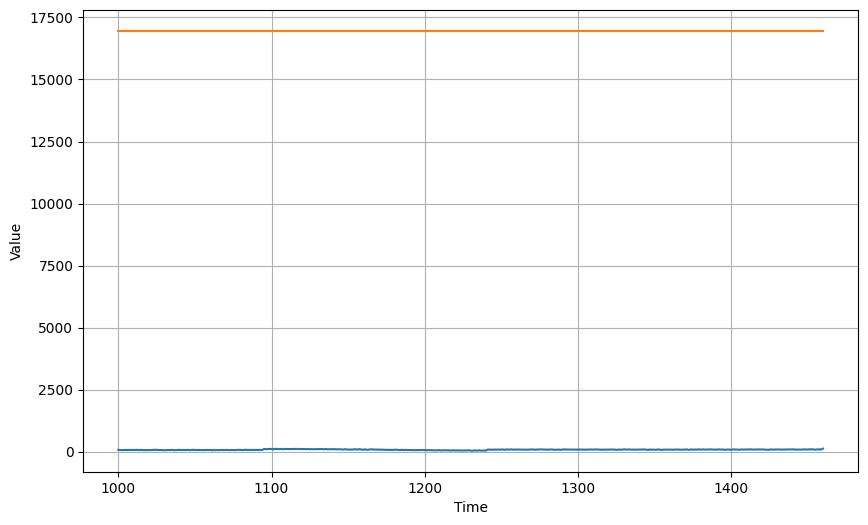

In [41]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [42]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

16886.793